In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np

from cluttered_mnist import ClutteredMNISTDataset
from gradcam import GradCAM
from cam import CAM
from models import ConvLinear, ConvGAP
from utils import AverageMeter

%matplotlib inline
import matplotlib.pyplot as plt
from visualizer import Heatmap

In [2]:
train_dataset = ClutteredMNISTDataset('../data/mnist_cluttered/', train=True, transform=transforms.ToTensor())
valid_dataset = ClutteredMNISTDataset('../data/mnist_cluttered/', train=False, transform=transforms.ToTensor())

processed dataset already exists; load it
processed dataset already exists; load it


In [3]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [4]:
def trainer(n_epochs, model):
    criterion = nn.CrossEntropyLoss().cuda()
    optimizer = torch.optim.Adam(model.parameters())

    total_loss = AverageMeter()
    total_acc = AverageMeter()

    for epoch in range(n_epochs):
        total_loss.reset()
        total_acc.reset()
        for X, y in train_loader:
            X = Variable(X).cuda()
            y = Variable(y).cuda()

            optimizer.zero_grad()
            y_ = model(X)
            loss = criterion(y_, y)
            loss.backward()
            optimizer.step()

            pred = y_.data.max(1)[1]
            acc = float(pred.eq(y.data).sum()) / train_loader.batch_size
            total_loss.update(loss.data[0])
            total_acc.update(acc)

        print("[TRAIN EPOCH {:2d}]\tLOSS {:.4f}\tACC {:.2%}".format(epoch+1, total_loss.avg, total_acc.avg))

        total_loss.reset()
        total_acc.reset()
        for X, y in valid_loader:
            X = Variable(X).cuda()
            y = Variable(y).cuda()

            y_ = model(X)
            loss = criterion(y_, y)
            
            pred = y_.data.max(1)[1]
            acc = float(pred.eq(y.data).sum()) / valid_loader.batch_size
            total_loss.update(loss.data[0])
            total_acc.update(acc)

        print("[VALID EPOCH {:2d}]\tLOSS {:.4f}\tACC {:.2%}".format(epoch+1, total_loss.avg, total_acc.avg))

In [5]:
def show_cam(model, st, ed):
    cam = CAM(model)
    
    for i in range(st, ed):
        X, y = valid_dataset[i]
        X_var = Variable(X.unsqueeze(0)).cuda()

        logits = cam.forward(X_var)
        index = logits.max(1)[1].data[0]
        activ_map = cam.activation_map(index)

        heatmap = Heatmap(X, activ_map)
        fig = heatmap.figure4()

In [6]:
def show_gradcam(model, st, ed):
    gradcam = GradCAM(model)
    
    for i in range(st, ed):
        X, y = valid_dataset[i]
        X_var = Variable(X.unsqueeze(0)).cuda()

        logits = gradcam.forward(X_var)
        gradcam.backward(logits)
        activ_map = gradcam.activation_map()

        heatmap = Heatmap(X, activ_map)
        fig = heatmap.figure4()

# ConvGAP

In [7]:
model = ConvGAP()
model.cuda()

ConvGAP (
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (linear): Linear (128 -> 10)
)

In [8]:
trainer(n_epochs=3, model=model)

[TRAIN EPOCH  1]	LOSS 1.5938	ACC 50.51%
[VALID EPOCH  1]	LOSS 0.4572	ACC 84.88%
[TRAIN EPOCH  2]	LOSS 0.2674	ACC 91.70%
[VALID EPOCH  2]	LOSS 0.1772	ACC 93.62%
[TRAIN EPOCH  3]	LOSS 0.1603	ACC 95.02%
[VALID EPOCH  3]	LOSS 0.1571	ACC 93.91%


## CAM

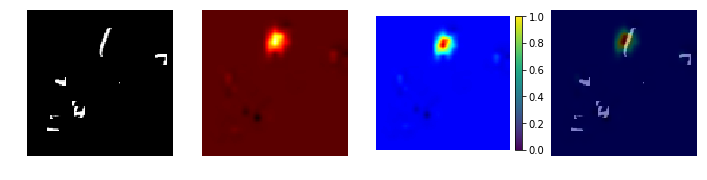

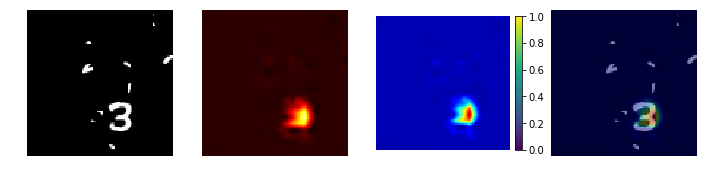

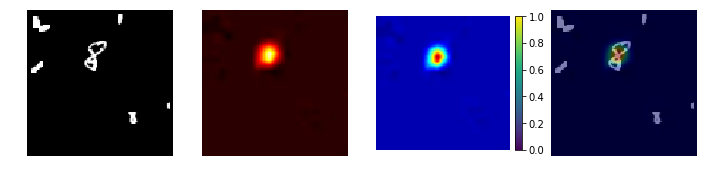

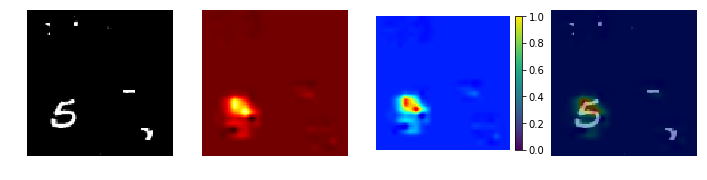

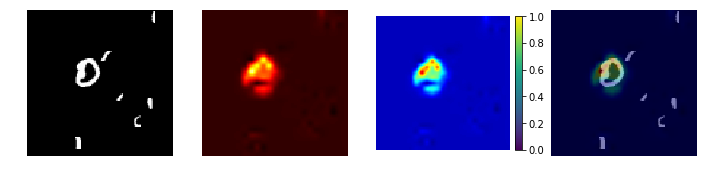

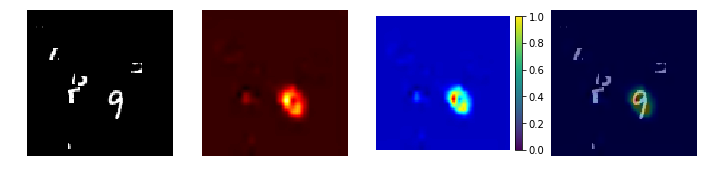

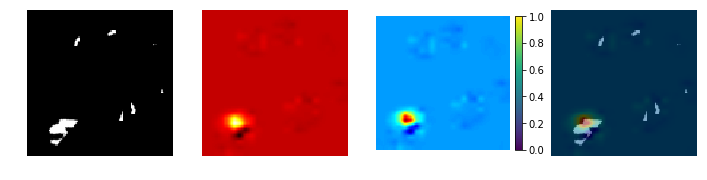

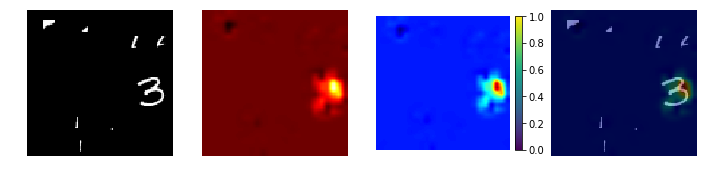

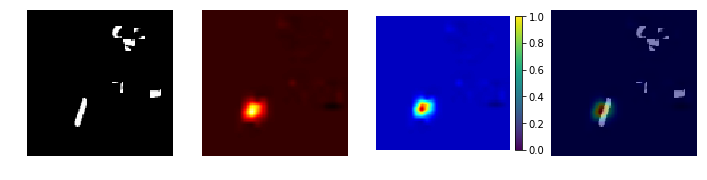

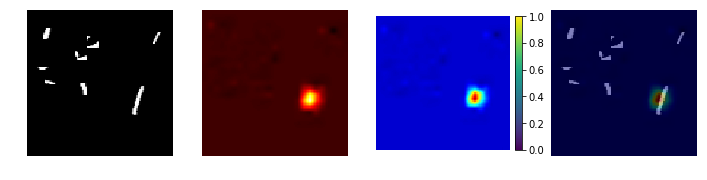

In [9]:
show_cam(model, 0, 10)

## GradCAM

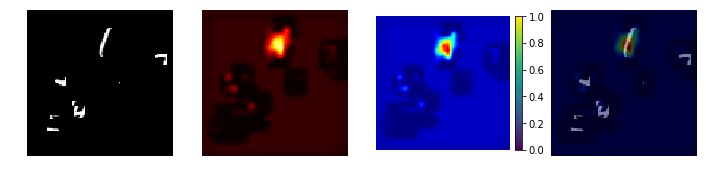

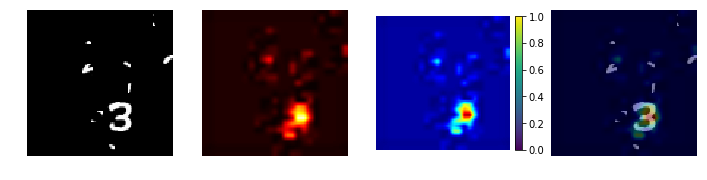

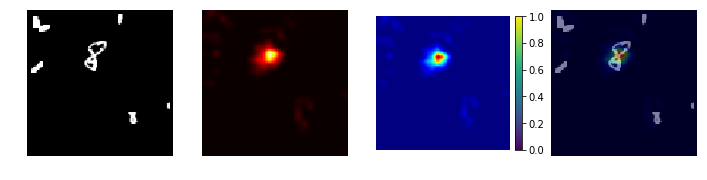

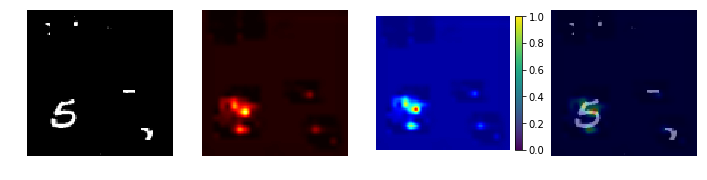

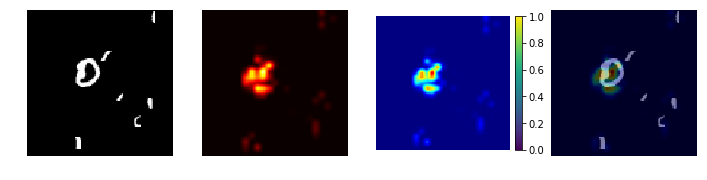

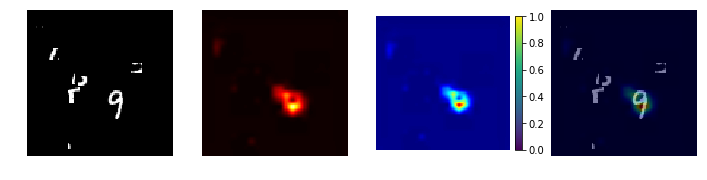

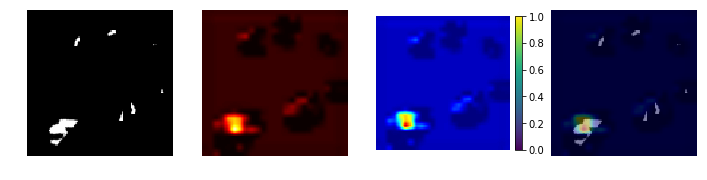

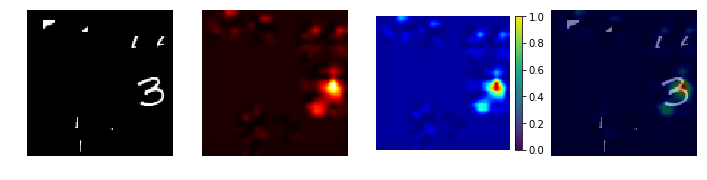

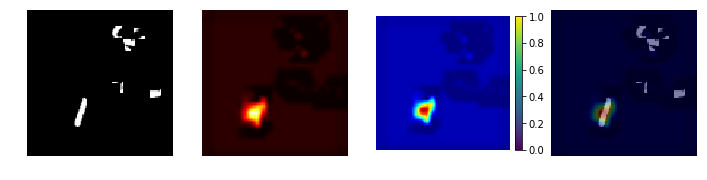

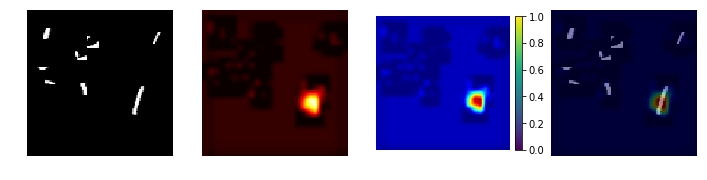

In [10]:
show_gradcam(model, 0, 10)

# ConvLinear

In [11]:
model = ConvLinear()
model.cuda()

ConvLinear (
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (linear1): Linear (4608 -> 256)
  (linear2): Linear (256 -> 10)
)

In [12]:
trainer(n_epochs=3, model=model)

[TRAIN EPOCH  1]	LOSS 0.9132	ACC 67.02%
[VALID EPOCH  1]	LOSS 0.1932	ACC 92.85%
[TRAIN EPOCH  2]	LOSS 0.1453	ACC 95.36%
[VALID EPOCH  2]	LOSS 0.1089	ACC 95.67%
[TRAIN EPOCH  3]	LOSS 0.0898	ACC 97.04%
[VALID EPOCH  3]	LOSS 0.1111	ACC 95.48%


## GradCAM

Since ConvLinear is non-GAP model, we can use GradCAM only.

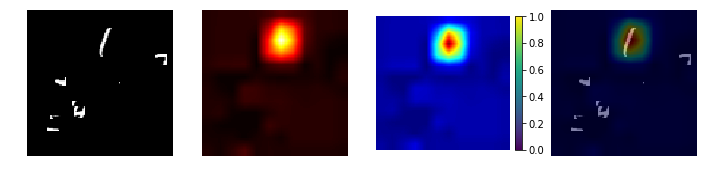

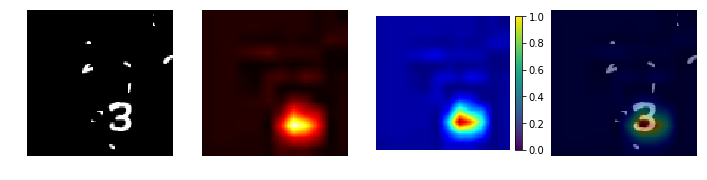

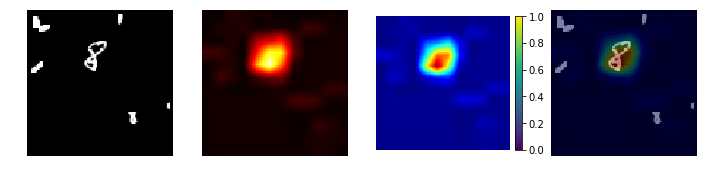

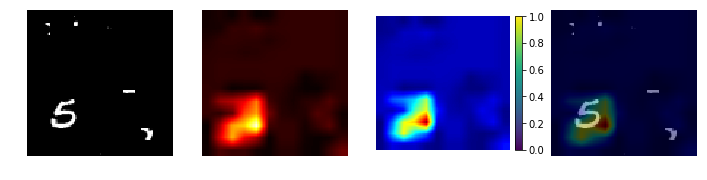

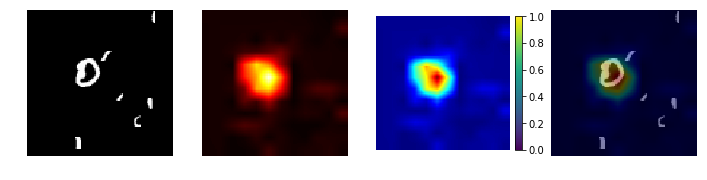

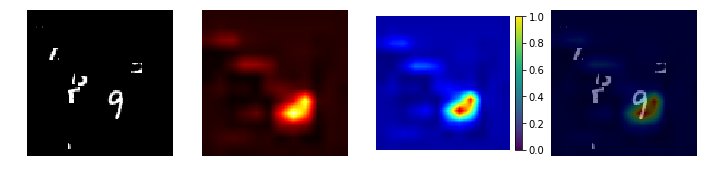

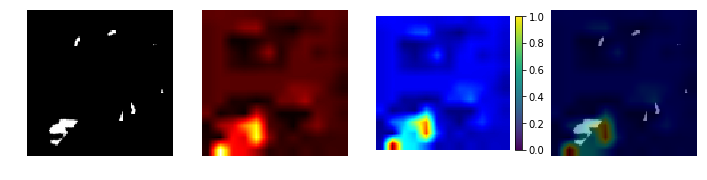

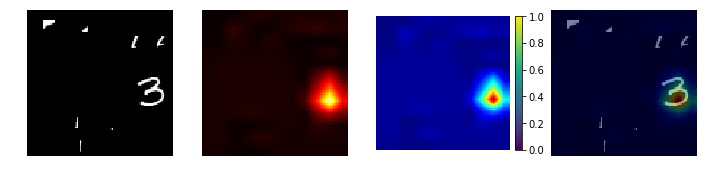

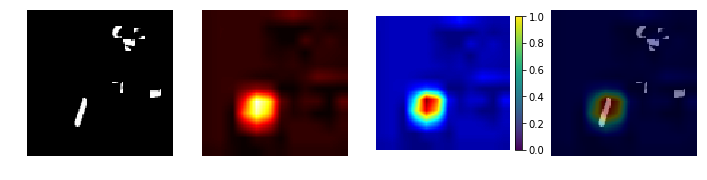

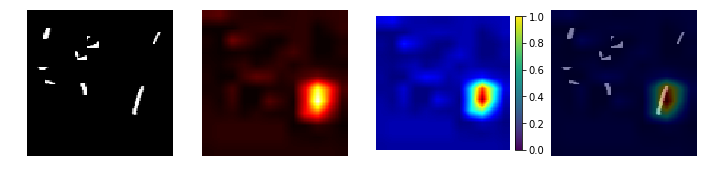

In [13]:
show_gradcam(model, 0, 10)